<a href="https://colab.research.google.com/github/satyendra-v/braille-flask/blob/master/Braille_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mouting Drive**

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


**Path to dataset**

In [ ]:
from pathlib import Path
rootdir = Path("/content/drive/MyDrive/Braille Dataset")

rootdir_new = Path("/content/drive/MyDrive/Braille Collected Dataset")

In [ ]:
import cv2
import random 
import os
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt


images = []
labels = []
path = []

for folder in os.listdir(rootdir):
  for image in os.listdir(str(rootdir) + '/' + folder):
    images.append(os.path.join(rootdir, folder, image))
    path.append(os.path.join(rootdir, folder, image))
    labels.append(folder)
    
every_cat = []
for folder in os.listdir(rootdir):
    for image in os.listdir(str(rootdir) + '/' + folder):
        every_cat.append(os.path.join(rootdir, folder, image))
        break

**Count Plot**

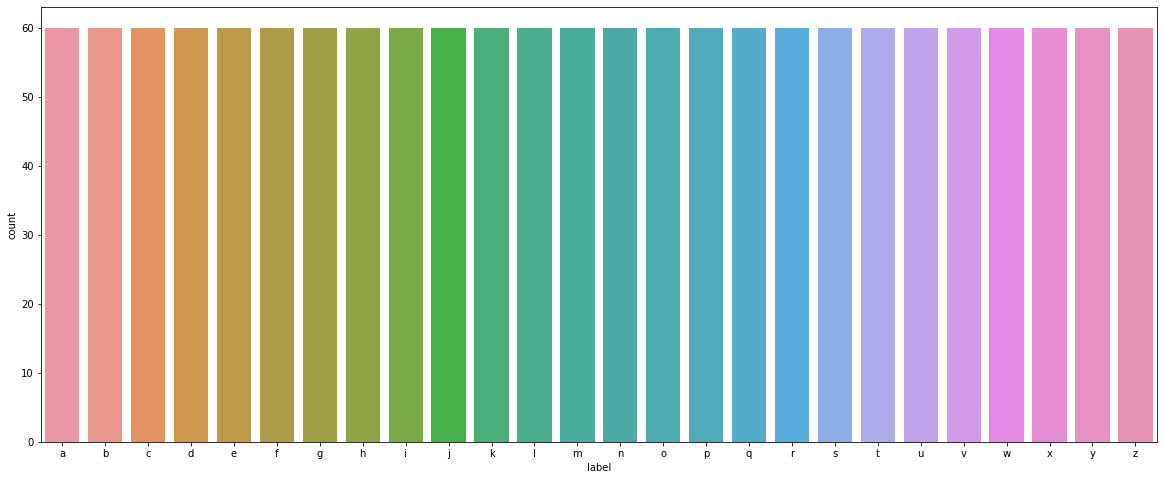

In [ ]:
data = pd.DataFrame(columns=['path','label'])
data['path'] = path
data['label'] = labels

data['label'] = data['label'].astype('category')

plt.figure(figsize=(20,8))
sns.countplot(data=data, x='label');

In [ ]:
data.head()

,path,label
1555,/content/drive/MyDrive/Braille Dataset/o/o1.JP...,o
1556,/content/drive/MyDrive/Braille Dataset/o/o1.JP...,o
1557,/content/drive/MyDrive/Braille Dataset/o/o1.JP...,o
1558,/content/drive/MyDrive/Braille Dataset/o/o1.JP...,o
1559,/content/drive/MyDrive/Braille Dataset/o/o1.JP...,o


**Plot of Every Category images**

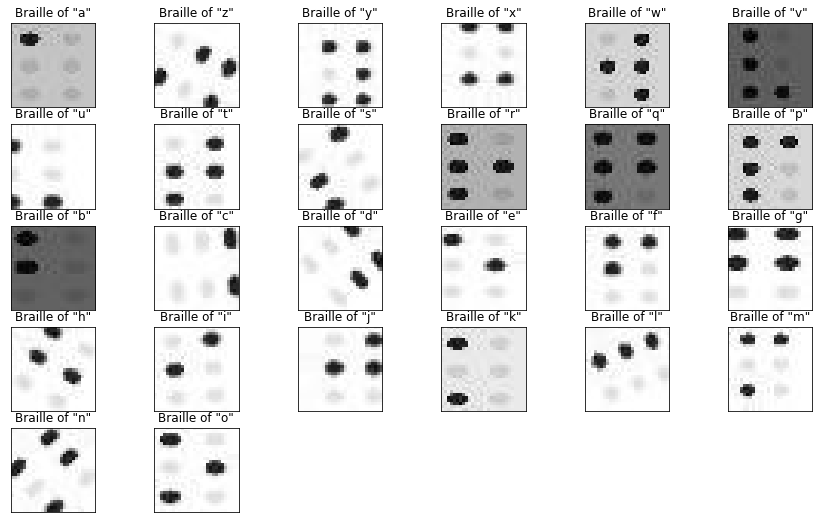

In [ ]:
#plot to show every category

plt.figure(1, figsize=(15, 9))
n = 0
for i in range(len(every_cat)):
  n += 1
  random_img = every_cat[i]
  imgs = cv2.imread(random_img)
  plt.subplot(5, 6, n)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(imgs)

  #Title of the image
  os.path.split(random_img)
  a = os.path.split(os.path.split(random_img)[0])
  title = "Braille of \"" +a[1]+"\""
  plt.title(title)

plt.show()

**Plot of some random images**

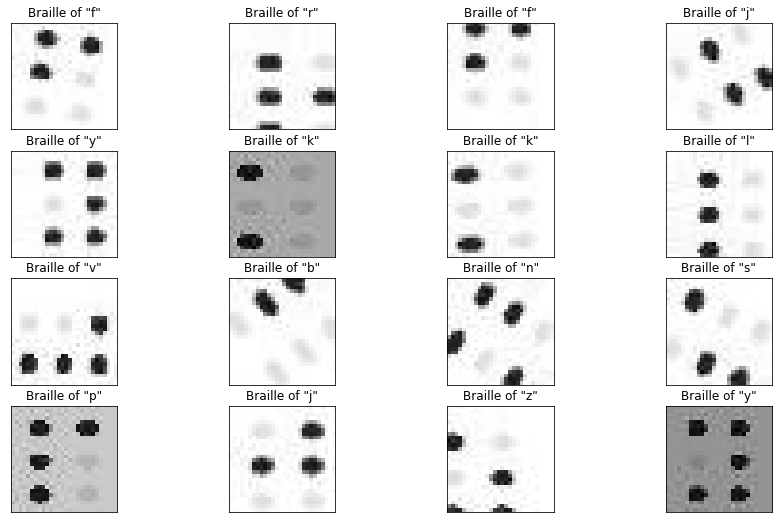

In [ ]:
#Plot to show some random images
import numpy as np

plt.figure(1, figsize=(15, 9))
n = 0
for i in range(16):
  n += 1
  random_img = random.choice(images)
  imgs = cv2.imread(random_img)
  plt.subplot(4, 4, n)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(imgs)
  os.path.split(random_img)

  #Title of the image
  a = os.path.split(os.path.split(random_img)[0])
  title = "Braille of \"" +a[1]+"\""
  plt.title(title)

plt.show()

**Data Augmentation for second dataset**

In [ ]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from functools import partial

root_directory = '/content/drive/MyDrive/Braille Collected Dataset'
list = ('a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z')
  
concat_root_path = partial(os.path.join, root_directory)
make_directory = partial(os.makedirs, exist_ok=True)
  
for path_items in map(concat_root_path, list):
    make_directory(path_items)

#Augmenting all images in "images" list
for img in new_images:
    full_name = os.path.split(img)[1] # a1.jpg
    name = full_name.split('.')[0]    # a1
    folder = name[0]                  # a
    img = load_img(img)
    data = img_to_array(img)
    samples = expand_dims(data,0)
    datagen = ImageDataGenerator(width_shift_range=[-1,1],
                                height_shift_range=0.1)
    it = datagen.flow(samples, batch_size=1)
    for i in range(9):
        batch = it.next()
        image = batch[0].astype('uint8')
        cv2.imwrite('/content/drive/MyDrive/Braille Collected Dataset/' + folder + '/' + name + '.aug' + str(i) +'.jpg',image)


**Splitting data to training and testing**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=20,
                             shear_range=10,
                             validation_split=0.2)

train_generator = datagen.flow_from_directory(rootdir,
                                              target_size=(28,28),
                                              subset='training')

val_generator = datagen.flow_from_directory(rootdir,
                                            target_size=(28,28),
                                            subset='validation')


Found 1248 images belonging to 27 classes.
Found 312 images belonging to 27 classes.


In [ ]:
train_generator_new = datagen.flow_from_directory(rootdir_new,
                                              target_size=(28,28),
                                              subset='training')

val_generator_new = datagen.flow_from_directory(rootdir_new,
                                            target_size=(28,28),
                                            subset='validation')


Found 696 images belonging to 27 classes.
Found 174 images belonging to 27 classes.


# **CNN Model**

In [ ]:
from keras import backend as K
from keras import layers as L
from keras.models import Model,load_model
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping

K.clear_session()
reduce_lr = ReduceLROnPlateau(patience=8,verbose=0)
early_stop = EarlyStopping(patience=15,verbose=1)

entry = L.Input(shape=(28,28,3))
x = L.SeparableConv2D(64,(3,3),activation='relu')(entry)
x = L.MaxPooling2D((2,2))(x)
x = L.SeparableConv2D(128,(3,3),activation='relu')(x)
x = L.MaxPooling2D((2,2))(x)
x = L.SeparableConv2D(256,(2,2),activation='relu')(x)
x = L.GlobalMaxPooling2D()(x)
x = L.Dense(256)(x)
x = L.LeakyReLU()(x)
x = L.Dense(64,kernel_regularizer=l2(2e-4))(x)
x = L.LeakyReLU()(x)
x = L.Dense(27,activation='softmax')(x)

model = Model(entry,x)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
history = model.fit_generator(train_generator,
                              validation_data=val_generator,
                              epochs=30,
                              callbacks=[reduce_lr,early_stop],
                              verbose=1)


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
39/39 [==============================] - 516s 12s/step - loss: 3.2972 - accuracy: 0.0553 - val_loss: 3.0692 - val_accuracy: 0.1635
Epoch 2/30
39/39 [==============================] - 2s 62ms/step - loss: 2.8680 - accuracy: 0.1980 - val_loss: 2.3107 - val_accuracy: 0.3077
Epoch 3/30
39/39 [==============================] - 2s 61ms/step - loss: 2.1942 - accuracy: 0.3599 - val_loss: 1.7611 - val_accuracy: 0.4808
Epoch 4/30
39/39 [==============================] - 2s 61ms/step - loss: 1.7754 - accuracy: 0.4718 - val_loss: 1.3978 - val_accuracy: 0.6378
Epoch 5/30
39/39 [==============================] - 2s 61ms/step - loss: 1.3924 - accuracy: 0.6364 - val_loss: 1.2686 - val_accuracy: 0.6346
Epoch 6/30
39/39 [==============================] - 2s 61ms/step - loss: 1.3071 - accuracy: 0.6238 - val_loss: 1.1284 - val_accuracy: 0.6667
Epoch 7/30
39/39 [==============================] - 2s 61ms/step - loss: 1.1508 - accuracy: 0.6784 - val_loss: 1.0527 - val_accuracy: 0.7340
Epoch 8/30
3

In [ ]:
model.fit_generator(train_generator_new,
                              validation_data=val_generator_new,
                              epochs=30,
                              callbacks=[reduce_lr,early_stop],
                              verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
22/22 [==============================] - 232s 11s/step - loss: 2.3898 - accuracy: 0.5086 - val_loss: 0.8024 - val_accuracy: 0.7644
Epoch 2/30
22/22 [==============================] - 1s 65ms/step - loss: 0.6063 - accuracy: 0.8118 - val_loss: 0.3949 - val_accuracy: 0.8851
Epoch 3/30
22/22 [==============================] - 1s 58ms/step - loss: 0.3546 - accuracy: 0.8966 - val_loss: 0.3225 - val_accuracy: 0.8851
Epoch 4/30
22/22 [==============================] - 1s 61ms/step - loss: 0.2194 - accuracy: 0.9382 - val_loss: 0.2267 - val_accuracy: 0.9425
Epoch 5/30
22/22 [==============================] - 1s 60ms/step - loss: 0.2340 - accuracy: 0.9138 - val_loss: 0.2727 - val_accuracy: 0.9138
Epoch 6/30
22/22 [==============================] - 1s 58ms/step - loss: 0.2170 - accuracy: 0.9267 - val_loss: 0.1799 - val_accuracy: 0.9655
Epoch 7/30
22/22 [==============================] - 1s 58ms/step - loss: 0.2357 - accuracy: 0.9282 - val_loss: 0.2507 - val_accuracy: 0.8966
Epoch 8/30
2

In [ ]:
model.save("/content/drive/MyDrive/BrailleNet.h5")

**Accuracy**

In [ ]:
    model = load_model('BrailleNet.h5')
    acc = model.evaluate_generator(val_generator_new)[1]
    print('model accuracy: {}'.format(round(acc,4)))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


model accuracy: 0.977


**Accuracy and Loss Curves**

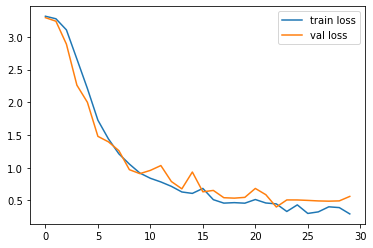

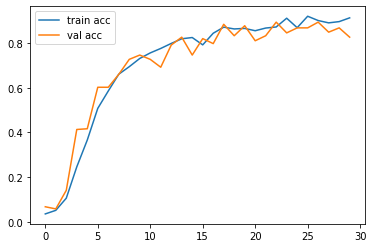

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
pred = model.predict(val_generator)
pred

array([[4.58342784e-15, 1.17463483e-18, 1.09388020e-14, ...,
        6.62189662e-01, 6.13027951e-04, 1.94490875e-17],
       [1.83265020e-05, 6.82300936e-08, 1.17776246e-04, ...,
        2.49982531e-06, 9.04216245e-03, 3.44971912e-10],
       [6.75183581e-03, 8.46578700e-08, 6.84255065e-06, ...,
        1.06689839e-11, 1.50135304e-09, 3.30860424e-08],
       ...,
       [1.62281050e-10, 1.46777495e-07, 1.71157988e-09, ...,
        2.30570033e-04, 1.10054157e-06, 1.18420612e-11],
       [2.59063467e-02, 3.42825006e-05, 8.60650398e-05, ...,
        2.43371368e-09, 2.15045137e-08, 2.82314686e-05],
       [2.47782990e-01, 5.21234300e-09, 4.80222487e-04, ...,
        2.21454655e-09, 5.32585138e-04, 4.84834963e-08]], dtype=float32)

# **Custom Input prediction**

In [ ]:
from imutils.perspective import four_point_transform as FPT
from collections import Counter
import matplotlib.pyplot as plt
from imutils import contours
from skimage import io
import numpy as np
import imutils
import cv2
import re
from tensorflow.keras.preprocessing import image

input = "/content/drive/MyDrive/Sample Braille Dataset/welcome to machine learning.png"
# welcome to machine learning

In [ ]:
def display(img):
  fig = plt.figure(figsize = (15,15))
  plt.imshow(img, cmap="gray")
  plt.axis('off')
  plt.show()

def display_segement(img):
  fig = plt.figure(figsize = (2,2))
  plt.imshow(img, cmap="gray")
  plt.axis('off')
  plt.show()

In [ ]:
def get_image(url, iter = 2, width = None):
  img = image.load_img(url)
  img = io.imread(url)
  if width:
    img = imutils.resize(img, width)
  ans = img.copy()
  accumEdged = np.zeros(img.shape[:2], dtype="uint8")
  # convert image to black and white
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  #print("gray")
  #display(gray)
  # blur to remove some of the noise
  blurred = cv2.GaussianBlur(gray, (5, 5), 0)
  #print("blurred")
  #display(blurred)
  # get edges
  edged = cv2.Canny(blurred, 75, 200)
  #print("edged")
  #display(edged)
  accumEdged = cv2.bitwise_or(accumEdged, edged)
  #print("accumEdged")
  #display(accumEdged)
  paper = img.copy()
  thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
  
  #print("thresh")
  #display(thresh)
  # erode and dilate to remove some of the unnecessary detail
  kernel = np.ones((5,5), np.uint8)
  thresh = cv2.erode(thresh, kernel, iterations = iter)
  #print("erode")
  #display(thresh)
  thresh = cv2.dilate(thresh, kernel, iterations = iter)
  #print("dilate")
  #display(thresh)

  return img, paper, gray, edged, thresh

img, paper, gray, edged, thresh = get_image(input, iter = 0, width = 1500)

**Image Segmentation**

In [ ]:
x, y, w, h = 10, 15, 45, 70

width_of_braille_cell = 55

height_of_braille_image, width_of_braille_image, ch = img.shape
no_of_braille_cells = width_of_braille_image // width_of_braille_cell

segments = []

segment = 1
for i in range(no_of_braille_cells):
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 1)
    # cv2.circle(img, (20,29), 5, (255, 25, 234), -1)
    new_img = img[y:y+h, x:x+w]
    # new_img = new_img.resize((28,28))
    crop = cv2.imwrite(str(segment)+".png", new_img)
    cv2.imwrite(str(segment)+".png", new_img)
    segments.append(str(segment)+".png")
    segment = segment+1
    x = x+55


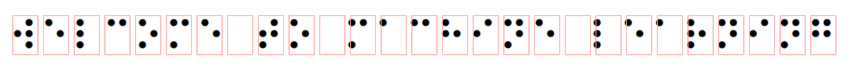

In [ ]:
 display(img)

In [ ]:
segments

['1.png',
 '2.png',
 '3.png',
 '4.png',
 '5.png',
 '6.png',
 '7.png',
 '8.png',
 '9.png',
 '10.png',
 '11.png',
 '12.png',
 '13.png',
 '14.png',
 '15.png',
 '16.png',
 '17.png',
 '18.png',
 '19.png',
 '20.png',
 '21.png',
 '22.png',
 '23.png',
 '24.png',
 '25.png',
 '26.png',
 '27.png']

In [ ]:
import numpy as np
import pandas as pd
def model_prediction(x):
    x=np.expand_dims(x,axis=0)
    model.predict(x)

def get_character(x):
    a=np.argmax(model.predict(x), axis=1)
    character = chr(ord('a')+a[0])
    return character

**Character classification using CNN Model**

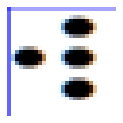

w
22


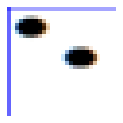

e
4


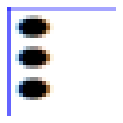

l
11


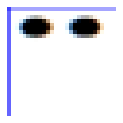

c
2


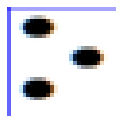

o
14


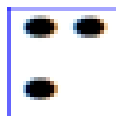

m
12


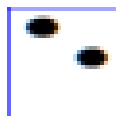

e
4


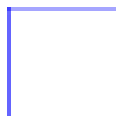

{
26


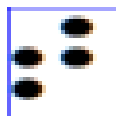

t
19


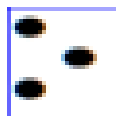

o
14


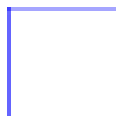

{
26


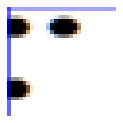

m
12


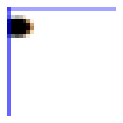

a
0


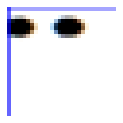

c
2


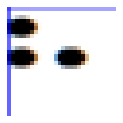

h
7


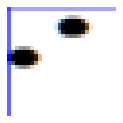

i
8


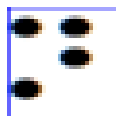

n
13


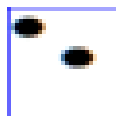

e
4


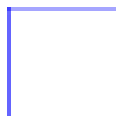

{
26


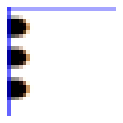

l
11


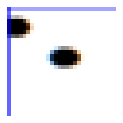

o
14


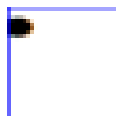

a
0


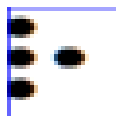

r
17


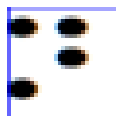

n
13


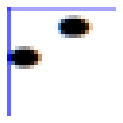

i
8


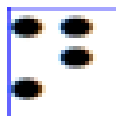

n
13


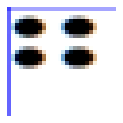

g
6


In [ ]:
final_text = ""

for seg in segments:
    seg1 = image.load_img(seg)
    seg1 = seg1.resize((28,28))
    display_segement(seg1)
    x=image.img_to_array(seg1)
    x=np.expand_dims(x,axis=0)
    a=np.argmax(model.predict(x), axis=1)
    character = chr(ord('a')+a[0])
    if(a[0] == 26):
        final_text = final_text + " "
    else:
        final_text = final_text + character
    print(character)
    print(a[0])

In [ ]:
final_text

'welcome to machine loarning'

In [ ]:
# single image prediction
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd

img=image.load_img('/content/drive/MyDrive/Braille Collected Dataset/a/a.aug0.jpg')
img= img.resize((28,28))

plt.imshow(img)

x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)

a=np.argmax(model.predict(x), axis=1)
character = chr(ord('a')+a[0])
character

In [ ]:
import numpy as np
import pandas as pd

x=np.expand_dims(x,axis=0)
model.predict(x)

array([[0.0000000e+00, 4.0442018e-19, 1.1874285e-26, 9.0631609e-09,
        0.0000000e+00, 4.8218183e-23, 9.9405235e-01, 2.6621496e-16,
        9.0727988e-38, 1.8130521e-11, 0.0000000e+00, 1.0752796e-27,
        0.0000000e+00, 6.4891863e-11, 5.7486674e-28, 9.6548602e-21,
        5.9469934e-03, 1.3456188e-13, 1.3540679e-14, 6.7775858e-07,
        4.6219651e-22, 5.4394051e-29, 2.8784032e-24, 0.0000000e+00,
        0.0000000e+00, 2.8576707e-24]], dtype=float32)

**Conversion of Text-to-Speech**

In [ ]:
!pip install gTTS
from gtts import gTTS
from IPython.display import Audio

speech_object = gTTS(text = final_text, lang='en', slow=False)
speech_object.save("speech.mp3")
Audio("speech.mp3", autoplay=True)